連結google雲端

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


環境設定及檢查使用GPU

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
import torchvision
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Use {device} for training')

Use cuda for training


Dataset準備

In [ ]:
# 解壓縮資料集
zip_path = '/content/drive/MyDrive/DL_Final/final_dataset.zip'
extract_dir = 'final_dataset'

if os.path.exists(zip_path):
    if not os.path.exists(extract_dir):
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Done!")
    else:
        print(f"Dataset {extract_dir} already exists.")
else:
    print(f"Error: {zip_path} not found. Please upload your zip file first!")

Extracting /content/drive/MyDrive/DL_Final/final_dataset.zip...
Done!


資料載入與預處理

Dataset sizes: {'train': 2316, 'val': 287, 'test': 293}


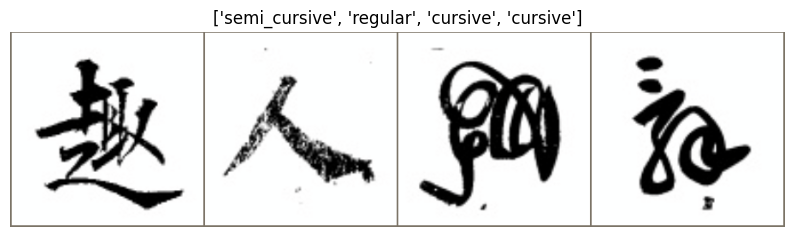

In [ ]:
# 設定超參數
BATCH_SIZE = 32
IMG_SIZE = 224
data_dir = 'final_dataset'

# 定義影像Data Augmentation & Normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # 224X224
        transforms.RandomHorizontalFlip(), # 加入隨機水平翻轉
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# 建立Dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), # datasets.ImageFolder自動完成轉RGB
          data_transforms[x])
   for x in ['train', 'val', 'test']}

# 建立 DataLoader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
        shuffle=(x=='train'), num_workers=2)
        for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

#print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # ImageNet的平均值進行標準化
    std = np.array([0.229, 0.224, 0.225]) # ImageNet的標準差進行標準化
    inp = std * inp + mean # 還原標準化
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title:
      plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:4])
plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])

定義訓練函式

In [ ]:
import time
import copy
import torch
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 # 紀錄最高的準確率

    # 記錄 Loss 和 Accuracy 的變化
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # 訓練迴圈epoch
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 每個Epoch都有訓練和驗證階段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 訓練模式
            else:
                model.eval()   # 評估模式


            running_loss = 0.0
            running_corrects = 0

            # 用tqdm顯示進度
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度歸零
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 得到預測結果
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward
                    if phase == 'train':
                        loss.backward() # 計算出梯度
                        optimizer.step() # 依照梯度更新模型參數

                # 統計數據
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 儲存紀錄
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # 深層複製模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 載入最佳權重並回傳
    model.load_state_dict(best_model_wts)
    return model, history

執行ResNet50訓練與結果視覺化

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


Epoch 1/10
----------


train: 100%|██████████| 73/73 [00:09<00:00,  7.56it/s]


train Loss: 0.9236 Acc: 0.6645


val: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s]


val Loss: 0.8230 Acc: 0.6376

Epoch 2/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  9.07it/s]


train Loss: 0.6491 Acc: 0.7539


val: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


val Loss: 0.5980 Acc: 0.7979

Epoch 3/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  8.86it/s]


train Loss: 0.5439 Acc: 0.8083


val: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s]


val Loss: 0.5631 Acc: 0.7875

Epoch 4/10
----------


train: 100%|██████████| 73/73 [00:09<00:00,  8.00it/s]


train Loss: 0.5308 Acc: 0.8005


val: 100%|██████████| 9/9 [00:01<00:00,  8.30it/s]


val Loss: 0.5949 Acc: 0.7631

Epoch 5/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  8.79it/s]


train Loss: 0.4824 Acc: 0.8269


val: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]


val Loss: 0.5157 Acc: 0.8118

Epoch 6/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  8.95it/s]


train Loss: 0.4605 Acc: 0.8381


val: 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


val Loss: 0.5078 Acc: 0.8153

Epoch 7/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  8.56it/s]


train Loss: 0.4803 Acc: 0.8139


val: 100%|██████████| 9/9 [00:01<00:00,  8.18it/s]


val Loss: 0.5461 Acc: 0.7840

Epoch 8/10
----------


train: 100%|██████████| 73/73 [00:07<00:00,  9.20it/s]


train Loss: 0.4314 Acc: 0.8415


val: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


val Loss: 0.5302 Acc: 0.7944

Epoch 9/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  8.84it/s]


train Loss: 0.4300 Acc: 0.8437


val: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s]


val Loss: 0.4645 Acc: 0.8153

Epoch 10/10
----------


train: 100%|██████████| 73/73 [00:08<00:00,  8.55it/s]


train Loss: 0.4136 Acc: 0.8497


val: 100%|██████████| 9/9 [00:01<00:00,  8.21it/s]


val Loss: 0.4528 Acc: 0.8188

Training complete in 1m 38s
Best val Acc: 0.818815
Model saved!


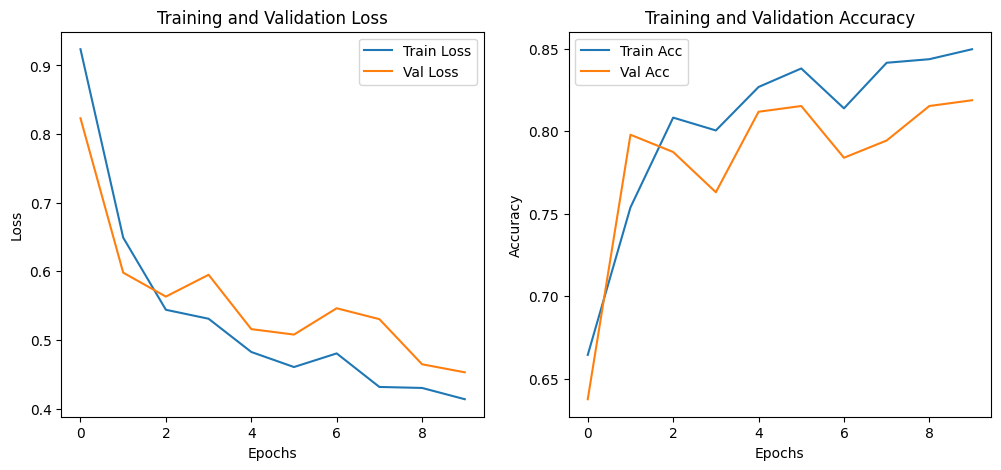

In [ ]:

# 1. 載入預訓練的ResNet50
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# 2. 凍結Backbone
for param in model_ft.parameters():
    param.requires_grad = False

# 3. 修改最後一層的全連接層(FC Layer)
# ResNet50 fc輸入特徵數是2048，類別數是5
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# 4. 定義Loss和Optimizer
criterion = nn.CrossEntropyLoss()

# 優化器於fc層
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

# 5. 開始訓練
# 10個Epoch
model_ft, history = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

# 6. 儲存模型
torch.save(model_ft.state_dict(), 'best_resnet50_calligraphy.pth')
print("Model saved!")


plt.figure(figsize=(12, 5))

# Loss曲線
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy曲線
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

ResNet自行上傳圖片測試預測辨識結果

請點擊下方按鈕上傳圖片 (支援多張)


Saving semi_cursive_00065.jpg to semi_cursive_00065.jpg


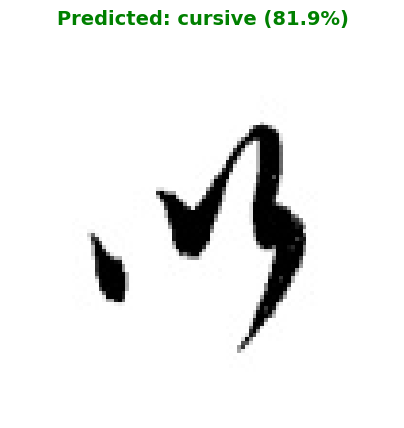

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import torch.nn.functional as F

def upload_img():
    """
    負責處理上傳，並回傳圖片物件與檔名
    """
    print("請點擊下方按鈕上傳圖片 (支援多張)")
    uploaded = files.upload()

    images = []
    for img_name in uploaded.keys():
        try:
            img = Image.open(img_name).convert('RGB')
            images.append((img, img_name))
        except Exception as e:
            print(f"Can't read{img_name}: {e}")

    return images

def eval_calligraphy(model):

    # 1. 上傳並取得圖片
    img_list = upload_img()

    # 如果沒有上傳圖片就結束
    if not img_list:
        print("No upload!")
        return

    # 設定模型為評估模式
    model.eval()
    model = model.to(device)

    # 2. 針對每一張圖進行預測
    for img, img_name in img_list:

        img_tensor = data_transforms['val'](img)
        img_tensor = img_tensor.unsqueeze(0) # 加 Batch 維度 (1, 3, 224, 224)
        img_tensor = img_tensor.to(device)

        # --- 預測 ---
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1) # 轉成機率
            prob, idx = probs.topk(1, dim=1)  # 取最高機率

            predicted_name = class_names[idx.item()]
            confidence = prob.item() * 100

        # --- 顯示結果 ---
        plt.figure(figsize=(5, 5))
        plt.imshow(img)

        # 設定標題：預測結果 + 信心分數
        plt.title(f"Predicted: {predicted_name} ({confidence:.1f}%)",
                  color='green', fontsize=14, fontweight='bold')
        plt.axis("off")
        plt.show()
if 'model_ft' in globals():
    eval_calligraphy(model_ft)

載入預訓練Transformer模型並執行訓練

In [ ]:
# ==========================================
# 設定ViT模型並執行訓練
# ==========================================
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# === 1.載入ViT預訓練模型 ===
# 載入Vision Transformer(ViT-Base-16)的架構與ImageNet權重
# ViT將圖片切成16x16來處理
model_vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# === 2.凍結主幹 ===
# 目的：ViT的參數量很大，不破壞已學好的「全局注意力機制」
# 先凍結並只訓練最後的分類器
for param in model_vit.parameters():
    param.requires_grad = False # 結凍解凍設定

# === 3.換頭 ===
# ViT在torchvision裡的分類層在.heads.head並替換
# 取得輸入特徵數(768 比ResNet的2048小)
num_ftrs = model_vit.heads.head.in_features

# 換上自己的分類層(輸出5類)
model_vit.heads.head = nn.Linear(num_ftrs, 5)

# 使用GPU
model_vit = model_vit.to(device)

# === 4.定義損失函數與優化器 ===
criterion = nn.CrossEntropyLoss()

# 優化器給model_vit的參數
# 學習率設定為0.001
optimizer_vit = optim.AdamW(model_vit.heads.head.parameters(), lr=0.001, weight_decay=0.01)

# === 5.訓練 ===
# 使用"訓練函式"的train_model函式
# ViT計算量較大 訓練時間可能會比ResNet久
best_vit, history_vit = train_model(model_vit, criterion, optimizer_vit, num_epochs=10)

# 儲存模型
torch.save(best_vit.state_dict(), 'best_vit_calligraphy.pth')
print("ViT模型已儲存！")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 199MB/s]


Epoch 1/10
----------


train: 100%|██████████| 73/73 [00:29<00:00,  2.45it/s]


train Loss: 0.8625 Acc: 0.6861


val: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


val Loss: 0.6614 Acc: 0.7735

Epoch 2/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.5491 Acc: 0.8139


val: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


val Loss: 0.5549 Acc: 0.7979

Epoch 3/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.54it/s]


train Loss: 0.4557 Acc: 0.8424


val: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


val Loss: 0.5141 Acc: 0.8118

Epoch 4/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.4076 Acc: 0.8666


val: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


val Loss: 0.4732 Acc: 0.8258

Epoch 5/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.3691 Acc: 0.8748


val: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


val Loss: 0.4416 Acc: 0.8328

Epoch 6/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.3452 Acc: 0.8834


val: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


val Loss: 0.4240 Acc: 0.8397

Epoch 7/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.3253 Acc: 0.8877


val: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


val Loss: 0.4034 Acc: 0.8571

Epoch 8/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.3045 Acc: 0.8981


val: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


val Loss: 0.3975 Acc: 0.8571

Epoch 9/10
----------


train: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


train Loss: 0.2874 Acc: 0.9050


val: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


val Loss: 0.3821 Acc: 0.8676

Epoch 10/10
----------


train: 100%|██████████| 73/73 [00:29<00:00,  2.51it/s]


train Loss: 0.2782 Acc: 0.9076


val: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


val Loss: 0.3888 Acc: 0.8537

Training complete in 5m 23s
Best val Acc: 0.867596
ViT模型已儲存！


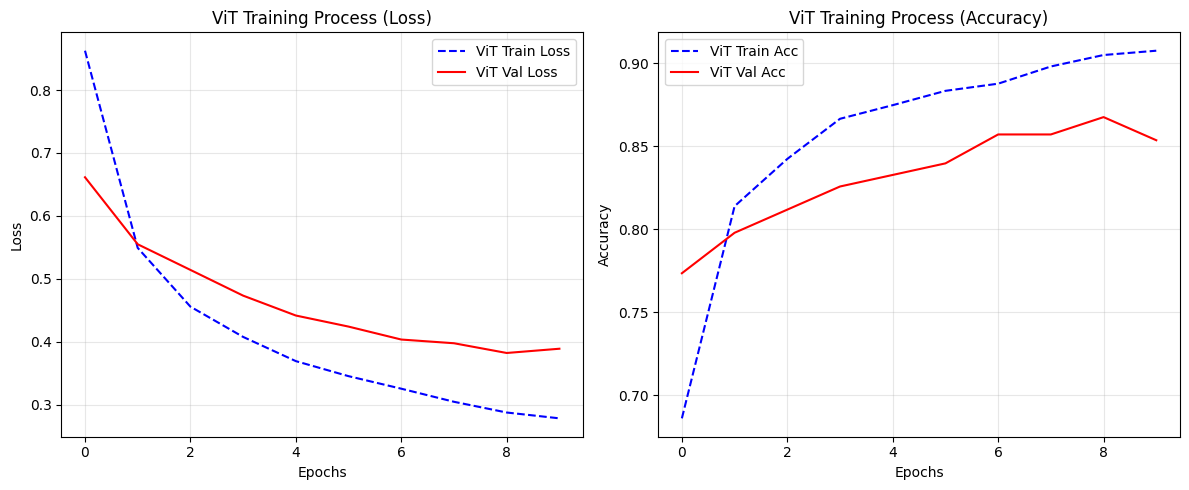

比較：
ResNet50 Best Val Acc: 0.8188
ViT-B/16 Best Val Acc: 0.8676


In [ ]:
# ==========================================
# ViT訓練結果
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- 繪製Loss ---
plt.subplot(1, 2, 1)
plt.plot(history_vit['train_loss'], label='ViT Train Loss', color='blue', linestyle='--')
plt.plot(history_vit['val_loss'], label='ViT Val Loss', color='red')
plt.title('ViT Training Process (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- 繪製Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history_vit['train_acc'], label='ViT Train Acc', color='blue', linestyle='--')
plt.plot(history_vit['val_acc'], label='ViT Val Acc', color='red')
plt.title('ViT Training Process (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 印出比較數據 ---
print("="*30)
print(f"比較：")
# 假設history是剛剛 ResNet 的紀錄
# history_vit是ViT的紀錄
# 取最後一個Epoch的驗證集準確率來比較
print(f"ResNet50 Best Val Acc: {max(history['val_acc']):.4f}")
print(f"ViT-B/16 Best Val Acc: {max(history_vit['val_acc']):.4f}")
print("="*30)

自行上傳圖片測試ViT預測辨識結果

請點擊下方按鈕上傳圖片 (支援多張)...


Saving semi_cursive_00462.jpg to semi_cursive_00462.jpg


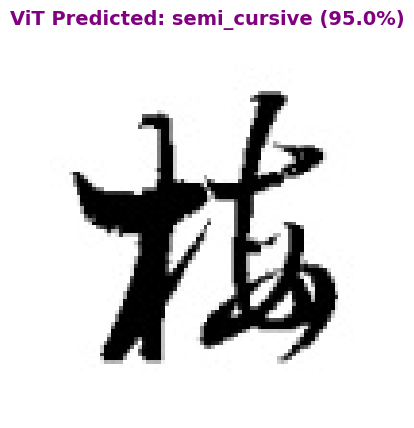

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import torch.nn.functional as F

def upload_img():
    """
    負責處理上傳，並回傳圖片物件與檔名
    """
    print("請點擊下方按鈕上傳圖片 (支援多張)...")
    uploaded = files.upload()

    images = []
    for img_name in uploaded.keys():
        try:
            img = Image.open(img_name).convert('RGB')
            images.append((img, img_name))
        except Exception as e:
            print(f"Can't read {img_name}: {e}")

    return images

def eval_vit(model):
    # 1. 上傳並取得圖片
    img_list = upload_img()

    # 如果沒有上傳圖片就結束
    if not img_list:
        print("沒有上傳圖片。")
        return

    # 設定模型-評估模式
    model.eval()
    model = model.to(device)

    # 2. 針對每一張圖進行預測
    for img, img_name in img_list:

        # --- 預處理 ---
        # 使用跟訓練時一樣的transform
        img_tensor = data_transforms['val'](img)
        img_tensor = img_tensor.unsqueeze(0) # 加 Batch 維度
        img_tensor = img_tensor.to(device)

        # --- 預測 ---
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1) # 轉成機率
            prob, idx = probs.topk(1, dim=1)  # 取最高機率

            predicted_name = class_names[idx.item()]
            confidence = prob.item() * 100

        # --- 顯示結果 ---
        plt.figure(figsize=(5, 5))
        plt.imshow(img)

        # 設定標題 (特別標註這是 ViT 的結果)
        plt.title(f"ViT Predicted: {predicted_name} ({confidence:.1f}%)",
                  color='purple', fontsize=14, fontweight='bold')
        plt.axis("off")
        plt.show()

# ==========================================
# 執行
# ==========================================
if 'model_vit' in globals():
    eval_vit(model_vit)
else:
    print("錯誤：找不到 'model_vit'")

Grad-CAM:利用Grad-CAM 取得神經網絡的分類關注區域熱力圖

In [ ]:
try:
    from pytorch_grad_cam import GradCAM
except ImportError:
    !pip install grad-cam
    from pytorch_grad_cam import GradCAM

from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import torch
import cv2

# ViT 的輸出是197個向量(1個類別 + 14x14個圖塊)
# 我們需要把那196個圖塊還原成14x14的2D圖
def vit_reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def visualize_gradcam(model, target_layers, image_path, class_names, is_vit=False):
    model.eval()

    for param in model.parameters():
        param.requires_grad = True # 改成TRUE才有梯度傳回

    # 1.讀取圖片
    try:
        img_pil = Image.open(image_path).convert('RGB')
    except:
        print(f"找不到圖片: {image_path}")
        return

    # 準備畫圖用的原始圖 (0~1 float)
    rgb_img = np.float32(img_pil.resize((224, 224))) / 255

    # 準備給模型的Tensor
    preprocess = data_transforms['val']
    input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

    # 2.初始化Grad-CAM
    # 如果是ViT 要傳入reshape_transform
    if is_vit:
        cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)
    else:
        cam = GradCAM(model=model, target_layers=target_layers)

    # 3.產生熱力圖
    try:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        # NONE = 自動找信心最高的類別
        grayscale_cam = grayscale_cam[0, :]

        # 疊加圖片
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # 取得預測結果文字
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            prob, idx = probs.topk(1, dim=1)
            pred_label = class_names[idx.item()]
            conf = prob.item() * 100

        # 4.呈現出熱力圖
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.title(f"Original\nPred: {pred_label} ({conf:.1f}%)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f"Grad-CAM Heatmap")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Grad-CAM 計算錯誤: {e}")

GRAD-CAM 兩者模型比較

上傳圖片進行Grad-CAM分析...


Saving semi_cursive_00636.jpg to semi_cursive_00636.jpg

正在分析圖片: semi_cursive_00636.jpg

[ResNet50]的關注區域：


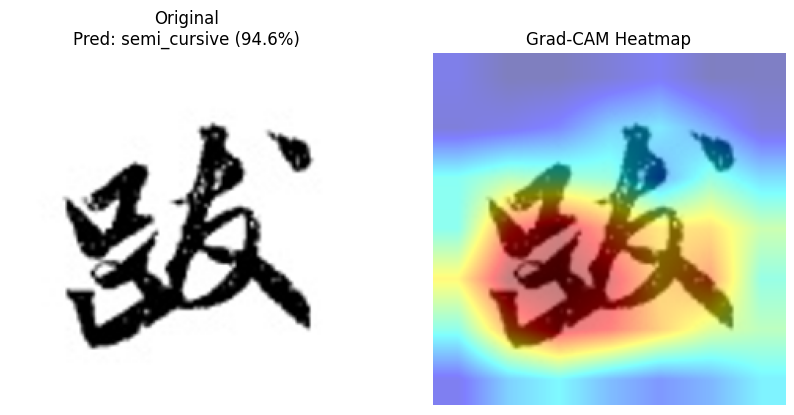


[ViT Transformer]的關注區域：


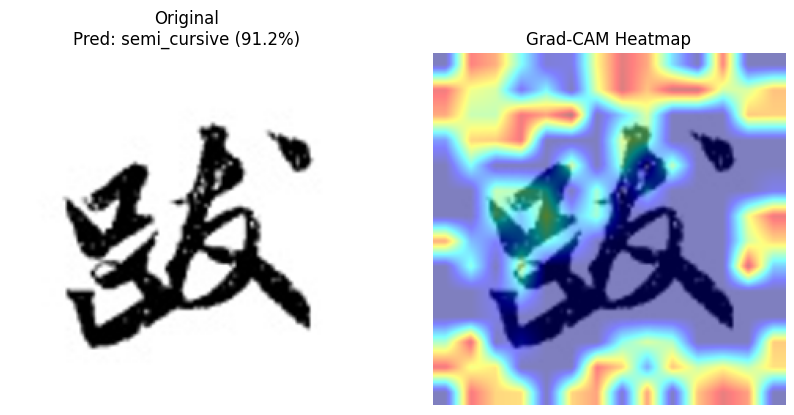

In [ ]:
from google.colab import files

# 設定ResNet的目標層 最後一個卷積層)
# ResNet50的最後一層卷積通常在layer4的最後Bottleneck
target_layer_resnet = [model_ft.layer4[-1]]

# 設定 ViT 的目標層 (最後一個LayerNorm)
# ViT 的特徵提取最後一步在encoder的最後一層
target_layer_vit = [model_vit.encoder.layers[-1].ln_1]

print("上傳圖片進行Grad-CAM分析...")
uploaded = files.upload()

for img_name in uploaded.keys():
    print(f"\n正在分析圖片: {img_name}")

    # 1.ResNet分析
    if 'model_ft' in globals():
        print("\n[ResNet50]的關注區域：")
        visualize_gradcam(model_ft, target_layer_resnet, img_name, class_names, is_vit=False)

    # 2.ViT分析
    if 'model_vit' in globals():
        print("\n[ViT Transformer]的關注區域：")
        visualize_gradcam(model_vit, target_layer_vit, img_name, class_names, is_vit=True)